In [51]:
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
from torchsummary import summary

import matplotlib.pyplot as plt

%matplotlib inline

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"using device: {device}")

using device: cuda


In [52]:
train_ds = MNIST("E:\datasets\mnist", train=True, transform=transforms.ToTensor(), download=True)
test_ds = MNIST("E:\datasets\mnist", train=False, transform=transforms.ToTensor(), download=True)
print(f"train set: {len(train_ds)}, test set: {len(test_ds)}")

In [53]:
train_dl = DataLoader(train_ds, batch_size=256, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=256, shuffle=False)

In [95]:
class SimpleAutoEncoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, self.latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 28*28),
            nn.Tanh()
        )

    def forward(self, xs):
        xs = xs.view(len(xs), -1)
        xs = self.encoder(xs)
        xs = self.decoder(xs)
        xs = xs.view(len(xs), 1, 28, 28)
        return xs

class AutoEncoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, self.latent_dim, kernel_size=7, padding=0)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(self.latent_dim, 64, kernel_size=7),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2),
            nn.Tanh()
        )

    def forward(self, xs):
        xs = self.encoder(xs)
        xs = self.decoder(xs)
        return xs

model = AutoEncoder(12).to(device)
summary(model, input_size=(1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
            Conv2d-7             [-1, 12, 1, 1]          37,644
   ConvTranspose2d-8             [-1, 64, 7, 7]          37,696
              ReLU-9             [-1, 64, 7, 7]               0
  ConvTranspose2d-10           [-1, 32, 14, 14]           8,224
             ReLU-11           [-1, 32, 14, 14]               0
  ConvTranspose2d-12            [-1, 1, 28, 28]             129
             Tanh-13            [-1, 1, 28, 28]               0
Total params: 102,509
Trainable params:

In [96]:
def train(model, xs, ys, lossfn, optim):
    model.train()
    ys_preds = model(xs)
    loss = lossfn(ys_preds, ys)

    optim.zero_grad()
    loss.backward()
    optim.step()

    return loss.item()

@torch.no_grad()
def test(model, xs, ys, lossfn):
    model.eval()
    ys_preds = model(xs)
    loss = lossfn(ys_preds, ys)

    return loss.item()

lossfn = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [97]:
import time
import numpy as np

train_losses = []
test_losses = []
for epoch in range(30):
    start = time.time()

    train_loss = []
    for xs, _ in train_dl:
        xs = xs.to(device)
        loss = train(model, xs, xs, lossfn, optimizer)
        train_loss.append(loss)
    train_loss = np.mean(train_loss)
    train_losses.append(train_loss)

    test_loss = []
    for xs, _ in test_dl:
        xs = xs.to(device)
        loss = test(model, xs, xs, lossfn)
        test_loss.append(loss)
    test_loss = np.mean(test_loss)
    test_losses.append(test_loss)

    consume = time.time() - start
    print(f"epoch {epoch}, consume: {consume:.1f}",
          f"train loss: {train_loss:.2f}, test loss: {test_loss:.2f}"
    )

epoch 0, consume: 3.8 train loss: 0.06, test loss: 0.04
epoch 1, consume: 3.9 train loss: 0.03, test loss: 0.02
epoch 2, consume: 4.0 train loss: 0.02, test loss: 0.02
epoch 3, consume: 4.0 train loss: 0.02, test loss: 0.02
epoch 4, consume: 4.0 train loss: 0.02, test loss: 0.02
epoch 5, consume: 4.0 train loss: 0.02, test loss: 0.02
epoch 6, consume: 4.0 train loss: 0.02, test loss: 0.02
epoch 7, consume: 4.1 train loss: 0.02, test loss: 0.02
epoch 8, consume: 4.0 train loss: 0.02, test loss: 0.01
epoch 9, consume: 3.9 train loss: 0.01, test loss: 0.01
epoch 10, consume: 3.9 train loss: 0.01, test loss: 0.01
epoch 11, consume: 3.9 train loss: 0.01, test loss: 0.01
epoch 12, consume: 4.0 train loss: 0.01, test loss: 0.01
epoch 13, consume: 4.1 train loss: 0.01, test loss: 0.01
epoch 14, consume: 3.9 train loss: 0.01, test loss: 0.01
epoch 15, consume: 4.0 train loss: 0.01, test loss: 0.01
epoch 16, consume: 4.0 train loss: 0.01, test loss: 0.01
epoch 17, consume: 4.0 train loss: 0.01, 

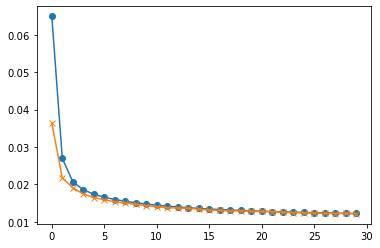

In [98]:
plt.plot(train_losses, marker='o')
plt.plot(test_losses, marker='x')

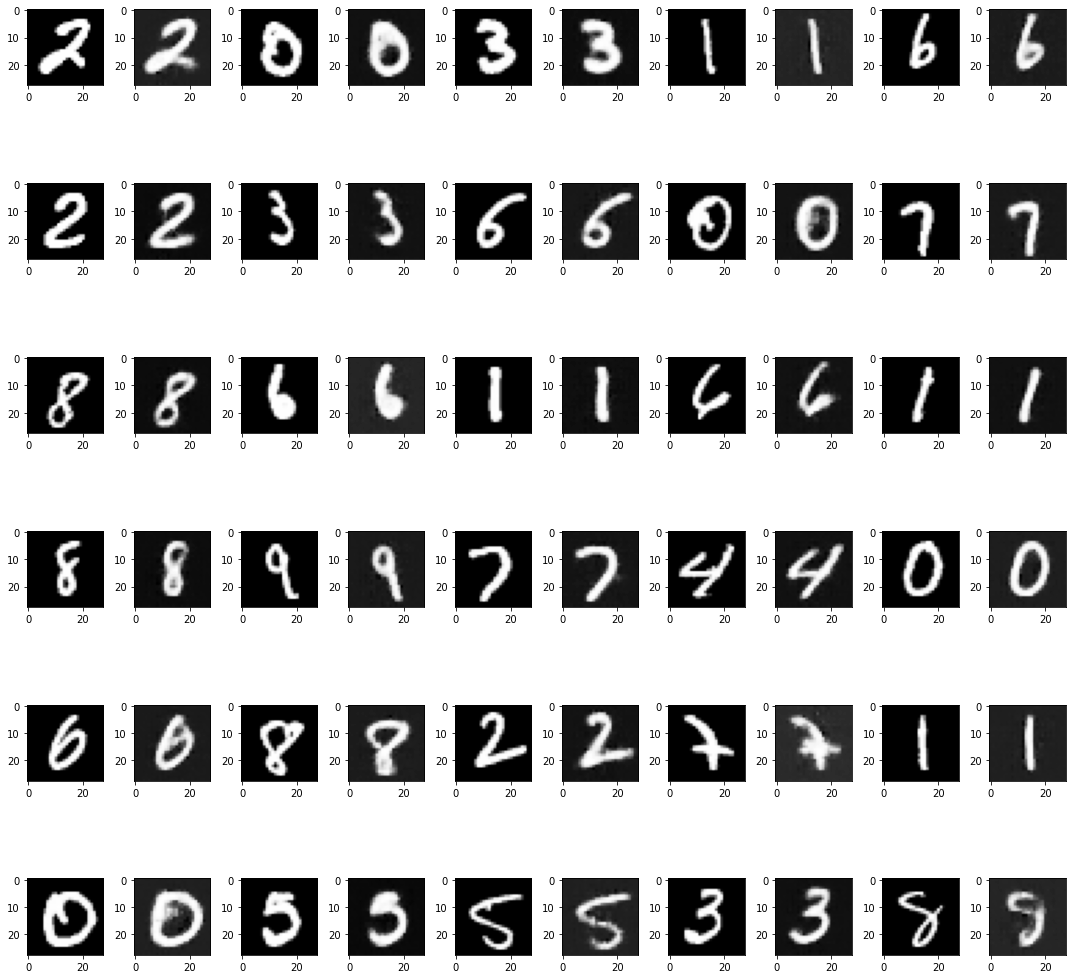

In [99]:
model.eval()
row, col = 6, 10
num_imgs = row * col // 2
fig, axes = plt.subplots(row, col, figsize=(15,15))
axes = list(axes.flatten())

for i in range(num_imgs):
    ix = np.random.randint(0, len(test_ds))
    image, _ = test_ds[ix]
    with torch.no_grad():
        pred = model(image.to(device).unsqueeze(0)).cpu()[0]
    axes[i*2].imshow(image.permute(1, 2, 0), cmap='Greys_r')
    axes[i*2+1].imshow(pred.permute(1, 2, 0), cmap='Greys_r')
plt.tight_layout()
plt.show()

C:\Users\liang\miniconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\liang\miniconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


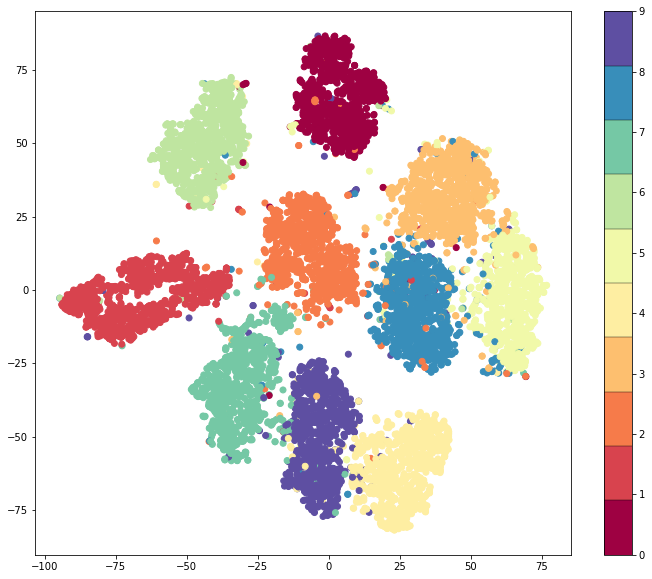

In [100]:
from sklearn.manifold import TSNE

latent_vectors = []
classes = []

for img, y in test_dl:
    classes.extend(y)
    latent = model.encoder(img.to(device)).cpu()
    latent = latent.view(len(latent), -1)
    latent_vectors.append(latent)

latent_vectors = torch.cat(latent_vectors).detach().numpy()
tsne = TSNE(2)
clustered = tsne.fit_transform(latent_vectors)
fig = plt.figure(figsize=(12, 10))
cmap = plt.get_cmap('Spectral', 10)
plt.scatter(*zip(*clustered), c=classes, cmap=cmap)
plt.colorbar(drawedges=True)

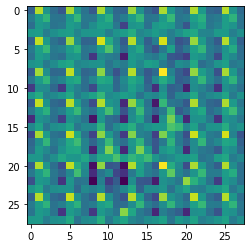

In [103]:
a = torch.rand(1, 12, 1, 1).to(device)
img = model.decoder(a)[0].cpu().detach()
plt.imshow(img.permute(1, 2, 0), cmap="Greys_r")